In [240]:
import numpy as np
import pandas as pd 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from scipy import spatial
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
snowballstemmer = SnowballStemmer("english")
from sklearn.neighbors import NearestNeighbors
import gensim.parsing.preprocessing as gsp


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marlonfacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marlonfacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [241]:
reviews=pd.read_csv("austin_reviews.csv")

We now want to explore the polarity scores generated by the TextBlob package. As it is rule based and does not take context into account we expect certain reviews to be misclassified. This can be seen below as many of the reviews with negative sentiment are actually positive reviews. 

In [242]:
reviews
reviews = reviews.dropna(axis=0, subset=['comments'])

In [243]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2265,963,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,1057,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,200418,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,1001630,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,1016390,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...
...,...,...,...,...,...,...
324568,47385871,721972440,2021-01-04,90722031,RYan,College area. but quick access to everything
324569,47411972,723017845,2021-01-09,125176457,Paul,Really loved staying here— I’m an Austin nativ...
324570,47411972,724050419,2021-01-13,280491070,Shanté,Kylen’s place was great! Communication was a b...
324571,47430860,723717982,2021-01-11,136891080,Roderick,I’ve been using Airbnb for more years with ple...


In [68]:
from textblob import TextBlob
temp = list(map(lambda x: TextBlob(x).sentiment, reviews['comments'].astype(str)))
reviews['Polarity'] = list(map(lambda x: x.polarity, temp))
reviews['Subjectivity'] = list(map(lambda x: x.subjectivity, temp))

KeyboardInterrupt: 

In [ ]:
revs_class = reviews[:100000]['Polarity'] < 0
neg_revs_idx = [i for i, x in enumerate(revs_class) if x]
neg_revs = [reviews.iloc[i] for i in neg_revs_idx]


In [ ]:
for i in range(len(neg_revs[:5])):
    print(neg_revs[i]['comments'] + '\n')

In [ ]:
len(reviews)

In [ ]:
for review in reviews['comments'][300010:300015]:
    print(review + "\n")

In [ ]:
# Read more data in
# import glob

# all_files = glob.glob("austin_reviews_2021_2019"+"/*.csv")
# li = []
# all_files[0]
# for filename in all_files:
#     df = pd.read_csv(filename)
#     li.append(df)
# listings_all = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
# Doc2Vec Article: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
# K-means Clustering: https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483
# BERT Explanation: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

As the TextBlob sentiment scorer was not trained on out data and is based on preset rules, we would like to see if we can improve our polarity scores by creating a custom model. We searched for labeled datasets that contained similar information to our reviews but were unable to find one. Due to this constraint, we decided to explore unsupervised algorithms. Many of the recent NLP algorithms use embeddings to classify the words/sentences/documents, so we decided to employ this strategy as well. We then aim to classify these vector embeddings with k-means clustering and generate a polarity score from the euclidean distance to the cluster centroids. 

In [285]:
# Create a tokenized version of each word in every review and format the data properly for the doc2vec model
tokenized_reviews = []
stop_words = set(stopwords.words('english')) 
for review in reviews['comments'][:100000]:
    tokenized_reviews.append([snowballstemmer.stem(w) for w in word_tokenize(gsp.strip_punctuation(review.lower())) if not w in stop_words])

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_reviews)]

We aim to create embeddings with the Doc2Vec model. This model generates an embedding using the fake task of predicting a word given a context and document. It trains a one layer neural network on this task and uses the weight matrix as the vector representation of the documents. 

In [286]:
# Default Doc2Vec model using averages of word contexts and document embeddings to predict words
d2v_model = Doc2Vec(tagged_data, vector_size = 256, window = 5, min_count = 1, epochs = 100)

In [289]:
test_doc = [snowballstemmer.stem(w) for w in word_tokenize(gsp.strip_punctuation(reviews['comments'].iloc[0].lower())) if not w in stop_words]
test_doc_vector = d2v_model.infer_vector(test_doc, epochs=30)
cosine_similarity(d2v_model.dv[0].reshape(1, -1), test_doc_vector.reshape(1, -1))

array([[0.66932523]], dtype=float32)

In [290]:
# See similar reviews to a negative review
test_doc = [snowballstemmer.stem(w) for w in word_tokenize('dirty messy gross disgusting') if not w in stop_words]
test_doc_vector = d2v_model.infer_vector(test_doc, epochs=30)
closest_rev_idx = [i[0] for i in d2v_model.dv.most_similar(positive = [test_doc_vector])]
d2v_model.dv.most_similar(positive = [test_doc_vector])

[(42308, 0.19653649628162384),
 (31970, 0.18660426139831543),
 (95377, 0.14167043566703796),
 (27681, 0.13790160417556763),
 (99819, 0.13698872923851013),
 (31226, 0.13193394243717194),
 (90924, 0.13136640191078186),
 (95393, 0.12852473556995392),
 (26759, 0.12535421550273895),
 (35504, 0.12395450472831726)]

In [86]:
# See similar reviews to the first review
test_doc = word_tokenize(reviews['comments'].iloc[0].lower())
test_doc_vector = d2v_model.infer_vector(test_doc)
closest_rev_idx = [i[0] for i in d2v_model.dv.most_similar(positive = [test_doc_vector])]
d2v_model.dv.most_similar(positive = [test_doc_vector])

[(21070, 0.5464547276496887),
 (61103, 0.5365825295448303),
 (55588, 0.5069388151168823),
 (0, 0.4949052035808563),
 (72178, 0.4899766445159912),
 (95607, 0.4849480092525482),
 (67246, 0.48282942175865173),
 (97071, 0.46936726570129395),
 (85816, 0.4651009738445282),
 (91846, 0.46304214000701904)]

In [291]:
print(reviews['comments'][0] + "\n")
for i in range(len(closest_rev_idx)):
    print(reviews['comments'][closest_rev_idx[i]] + "\n")


I stayed here during SXSW and had a really pleasant stay.  The house is a very relaxing environment and Paddy is both a friendly and professional host. 

Me and my group of 7 throughly enjoyed our stay here. The layout and location were great and the amenities made our stay even better! The speaker system was the hit of the house.

Cozy and beautiful space, lovely family, wish we could've stayed longer!

Accurate pictures, clean, great location, and wonderful hosts. Patrick and Catherine shared great tips. I would definitely recommend to a friend.

The house was cute and convenient. Angel was extremely responsive when we had issues and turned up within 30 minutes.

amazing

Good location in central in Austin. Not as nice as in the photos, but still accommodated 5 comfortably. Could have been cleaner, but did the trick. Beware of an additional fee before booking!! Austin will send you a separate charge for local taxes that was not well advertised in the description.

Great location.

Pr

Now that we have our embeddings we can get 2 clusters. 

In [223]:
# Use K means cluster to get 3 clusters
k_means_model = KMeans(n_clusters=3, max_iter=1000, n_init=50, init='k-means++').fit(X=d2v_model.dv.vectors)
positive_cluster_center = k_means_model.cluster_centers_[0]
negative_cluster_center = k_means_model.cluster_centers_[1]
neutral_cluster_center = k_means_model.cluster_centers_[1]

In [224]:
top_clust_0_rev_idx = [i[0] for i in d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[0], topn=10, restrict_vocab=None)]
d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[0], topn=10, restrict_vocab=None)

[(24564, 0.9655185341835022),
 (88111, 0.965106189250946),
 (94410, 0.9634459018707275),
 (69203, 0.962386429309845),
 (59717, 0.9610052704811096),
 (53089, 0.9608986973762512),
 (35190, 0.9606471657752991),
 (39958, 0.9602821469306946),
 (70728, 0.9601920247077942),
 (17189, 0.9593513011932373)]

In [225]:
for i in range(len(top_clust_0_rev_idx)):
    print(reviews['comments'][top_clust_0_rev_idx[i]] + "\n")

We had a great trip and enjoyed staying here. It was close to downtown through Uber. Would definitely recommend this location for a long weekend!

This house was wonderful! Great size and location for a group trip, wonderful porch to sit on when it wasn't too hot, and Chelsea was fabulous about getting back to us about any questions we had. 

Attended a conference and the convention center.  Location could not have been any better.  Much closer than you might think.  So close that I could run back to the condo to send an important email or just take a break away from the conference.  Separate from the convention center, you are right in the downtown action.  Easily walkable to great downtown restaurants, Capitol, and a :30 minute walk to the University (I made the walk there and rented a bike back).  The public bike rentals are fantastic and everywhere downtown so you can get a bit further, faster, if you wanted to.
Overall very clean, comfortable bed, full kitchen etc..... No complain

In [226]:
top_clust_1_rev_idx = [i[0] for i in d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[1], topn=10, restrict_vocab=None)]
d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[1], topn=10, restrict_vocab=None)

[(27999, 0.9569502472877502),
 (97565, 0.9566595554351807),
 (69203, 0.9563988447189331),
 (26251, 0.9553472399711609),
 (17189, 0.9553171396255493),
 (39958, 0.9552882313728333),
 (92207, 0.9549301862716675),
 (24564, 0.9545774459838867),
 (6591, 0.9543002843856812),
 (24671, 0.9538354873657227)]

In [227]:
for i in range(len(top_clust_1_rev_idx)):
    print(reviews['comments'][top_clust_1_rev_idx[i]] + "\n")

The reservation was canceled 171 days before arrival. This is an automated posting.

Lacey and Trey are awesome hosts! The studio is so cute, comfy, welcoming and spacious. Their backyard is a quiet oasis in busy Austin. We enjoyed coffee in the mornings with the chickens quietly clucking and pecking nearby.  Great location with easy access to downtown Austin and other sites. We have already recommended the place to family and friends.

This place is exactly as advertised. It's nothing fancy, but it gets the job done on a budget. It is basic but worked for my family on a one night stay.

Great location, excellent backyard space. Thank you for having us!

This great was a perfect place for our group to stay while taking our yearly girls trip.  Location to downtown was perfect, PLENTY of room in this house and the 4 bathrooms is ideal for a group of 8 women to get ready.  Had everything we needed for our long weekend.

The house was immaculate, the neighborhood adorable and safe, and our

In [228]:
top_clust_2_rev_idx = [i[0] for i in d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[2], topn=10, restrict_vocab=None)]
d2v_model.dv.similar_by_vector(k_means_model.cluster_centers_[2], topn=10, restrict_vocab=None)

[(58614, 0.9042880535125732),
 (16101, 0.9007985591888428),
 (70728, 0.9002487659454346),
 (84359, 0.8978692889213562),
 (94410, 0.8974800109863281),
 (35252, 0.8965250253677368),
 (19185, 0.896359920501709),
 (13905, 0.8957037925720215),
 (60642, 0.895522952079773),
 (91127, 0.8953238129615784)]

In [229]:
for i in range(len(top_clust_2_rev_idx)):
    print(reviews['comments'][top_clust_2_rev_idx[i]] + "\n")

Great accommodation with lots of modern amenities like Amazon Alexa included.  Parking is the only issue I had with this place.  Other than that - the stay was perfect.  

Cindie Brooks and her Heart of Tarrytown, Bed and Bath were the perfect welcome to Austin for me. The room and bath were comfortable and clean. The house is located in a beautiful and safe neighborhood, Tarrytown, which happens to be within walking distance to a river and several great restaurants along the river. What made my experience the most memorable though, was Cindie herself. She is warm, welcoming, and generous. I would recommend her Bed and Bath to anyone, and think it is perfect for a female traveler whose priorities are comfort and safety.  

Wonderful location. Amazing backyard. Clean and well kept. Charming home perfect for a weekend getaway

Host, location and room was WAY more than what was ever expected. Neighborhood is safe and in the most excellent location. Bus was handy on more than one occasion.

In [230]:
cosine_similarity(k_means_model.cluster_centers_[1].reshape(1,-1), k_means_model.cluster_centers_[2].reshape(1,-1))

array([[0.85209817]], dtype=float32)

In [94]:
review_scores = pd.DataFrame(d2v_model.dv.vocab.keys())
review_scores.columns = ['reviews']
# review_scores['vectors'] = review_scores.words.apply(lambda x: word_vectors.wv[f'{x}'])
# review_scroes['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
# review_scores.cluster = words.cluster.apply(lambda x: x[0])
# review_scores['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
# review_scores['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
# review_scores['sentiment_coeff'] = words.closeness_score * words.cluster_value
review_scores

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [95]:
sbert_model = SentenceTransformer('stsb-roberta-base')

In [256]:
cleaned_reviews = [" ".join(rev) for rev in tokenized_reviews]

In [194]:
cleaned_reviews[0]

'stay sxsw realli pleasant stay . hous relax environ paddi friend profession host .'

In [274]:
sentence_embeddings = sbert_model.encode(cleaned_reviews[:1000])

In [275]:
k_means_model = KMeans(n_clusters=2, max_iter=1000, n_init=50).fit(X=sentence_embeddings)
positive_cluster_center = k_means_model.cluster_centers_[0]
negative_cluster_center = k_means_model.cluster_centers_[1]

In [277]:
distances = spatial.distance.cdist(np.array([positive_cluster_center]), sentence_embeddings, "cosine")[0]
min_idx = np.argmin(distances)
print(min_idx)
print(reviews['comments'][min_idx])
print("\n")
distances = spatial.distance.cdist(np.array([negative_cluster_center]), sentence_embeddings, "cosine")[0]
min_idx = np.argmin(distances)
print(min_idx)
print(reviews['comments'][min_idx])

807
Elizabeth is a gracious host and probably one of the nicest people I've ever met. The room, and her home, are inviting and cozy. The personal touches and amenities make you feel welcome. The neighborhood is scenic, quiet and close to everything one would need. I look forward to booking there again. I highly recommend staying here!


856
Todd and Amy's place is really fantastic - totally up-to-date, beautifully furnished, very clean-- and you even have your own private patio!  It felt absolutely comfortable, and - dare I say? - luxurious.  The studio is perfectly located between downtown Austin and Austin's fun and hip Soco neighborhood.  If you're coming to Austin for SXSW, you'll be perfectly located (an easy 15 minute walk to the Convention Center) and you'll find that this place offers a lovely, peaceful respite from the fast-paced and frenzied SXSW environment.  Todd and Amy were very gracious hosts, helping me get settled in and answering all my "Austin newbie" queries.  They 

In [279]:
neg_embedding = sbert_model.encode(["dirty gross messy bad. dont like this place at all. Very bad place to stay."])

In [280]:
distances = spatial.distance.cdist(neg_embedding, sentence_embeddings, "cosine")[0]
min_index = np.argmin(distances)
print(min_index)
print(reviews['comments'][min_index])
min_distance = distances[min_index]
max_similarity = 1 - min_distance

118
Top notch place to stay while in one of the greatest cities in the world. Guests have everything they could possibly need, a kitchen, bathroom and comfortable bed to rest. Sylvia is a quality person to-get-to know and very knowledgeable on the area. You can't go wrong staying literally a hop, skip and a jump from downtown.


In [281]:
cosine_similarity(k_means_model.cluster_centers_[0].reshape(1,-1), k_means_model.cluster_centers_[1].reshape(1,-1))

array([[0.8731273]], dtype=float32)

In [63]:
with open('embeddings.npy', 'wb') as f:
    np.save(f, np.array(sentence_embeddings))


In [167]:
sentence_embeddings = np.load('embeddings.npy')

In [261]:
cleaned_reviews


['stay sxsw realli pleasant stay hous relax environ paddi friend profession host',
 'great place close enough everyth downtown austin yet far enough relax quiet excel place regroup recharg paddi respect privaci differ hour place clean hip would stay paddi must okay dog',
 'great time austin stay paddi hous hous much larger look photo clean moment step feel like home hesit stay next time back austin',
 'great stay zen east south southwest paddi extrem accommod found place exot home easi settl right experi austin everyth short taxi bus ride away everyth need stay love zen vibe backyard garden',
 'arriv late even meet paddi home love clean welcom check friend day make sure question need anyth smooth stress free experi austin',
 'realli welcom place stay love back yard relax space amaz littl grocer wet whistl sandwich shop austin daili press within block walk love neighborhood utilitarian use corner store liter block away excel communic easi time coordin',
 'stay f1 race weekend perfect pa

In [257]:
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(cleaned_reviews).toarray()

In [258]:
model = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [259]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidfconverter.get_feature_names()

In [260]:
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 great
 locat
 place
 stay
 host
 clean
 would
 recommend
 austin
 space
Cluster 1:
 stay
 place
 great
 austin
 locat
 hous
 perfect
 clean
 host
 would


In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

In [248]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in enumerate(tokenized_reviews):
    c = Counter(row)
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

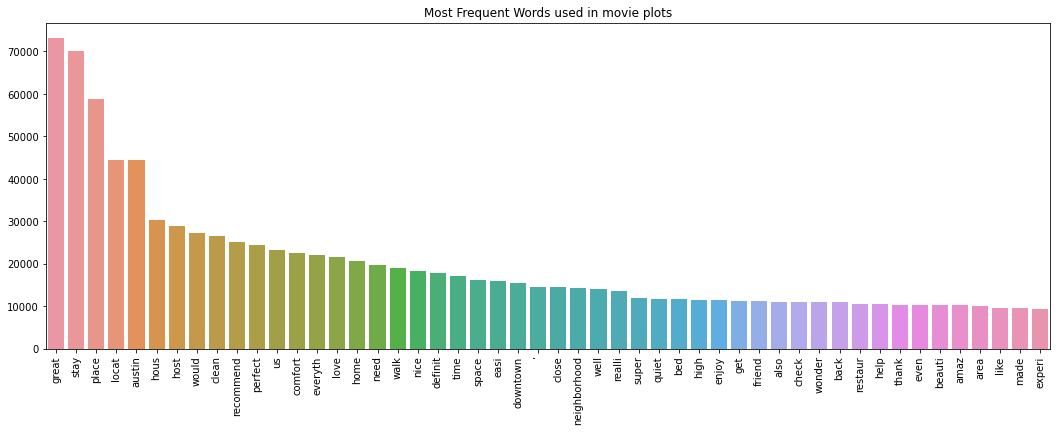

In [249]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in movie plots')

In [292]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(d2v_model.dv.vectors, d2v_model.dv.vectors)
predicted_vectors = auto_encoder.predict(d2v_model.dv.vectors)

In [293]:
auto_encoder.score(predicted_vectors, d2v_model.dv.vectors)

0.6468306788123267

In [297]:
from scipy.spatial.distance import cosine

def key_cosine_similarity(tuple):
    return tuple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(tokenized_reviews)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_cosine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, cosine_sim_val = sorted_cosine_similarities[i]
        print('Review: ', index)  
        print('Cosine Sim Val :', cosine_sim_val)
        print('---------------------------------')

In [298]:
sorted_cosine_similarities = get_computed_similarities(vectors=d2v_model.dv.vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Review:  14962
Cosine Sim Val : -0.178434818983078
---------------------------------
Review:  72273
Cosine Sim Val : -0.16115577518939972
---------------------------------
Review:  52886
Cosine Sim Val : -0.14637590944766998
---------------------------------
Review:  24424
Cosine Sim Val : -0.07232582569122314
---------------------------------
Review:  82486
Cosine Sim Val : -0.06241752579808235
---------------------------------


In [301]:
reviews['comments'][52886]

'Beautiful home I️ will definitely book this house again. The location is perfect and Brad we very friendly and accommodating. '